# Sentence Transformer Embedding based Topics Modelling and Prediction

Importing Libraries
--

In [1]:
from pre_process import *

Loading Libraries...Just a moment please!...


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gurpreetbedi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/gurpreetbedi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Loading dataset
--

In [2]:
path = "/Users/gurpreetbedi/Downloads/Neural/Indeed_local/source_data/"

In [3]:
art_train = load_data(f"{path}article.json")
art_test = load_data(f"{path}pred_article.json")

art_test = remove_hyperlinks_html_tags(art_test, "content")
art_train = remove_hyperlinks_html_tags(art_train, "content")

art_test["cont_title"] = art_test["contentTitle"] + " " +art_test["content"]
art_train["cont_title"] = art_train["contentTitle"] + " " +art_train["content"]

Shape of pre-processed data
--

In [4]:
print("After pre-processing the raw data: ")
print(f'Shape of the article from taining corpus: {art_train.shape}')
print(f'Shape of the article from test corpus: {art_test.shape}')

After pre-processing the raw data: 
Shape of the article from taining corpus: (13639, 8)
Shape of the article from test corpus: (1417, 7)


Load sentence ransformer embeddings
--

In [6]:
embedding_model = "msmarco-MiniLM-L-12-v3"
device = "cuda" if torch.cuda.is_available else "cpu"
documents = list(art_train["cont_title"])
sent_embeddings = Sentence_Encoder(embedding_model).embed_documents(documents,device=device)

In [7]:
print(f'Shape of Sentence Transformer embeddings of the articles from training corpus : {art_train.shape}')

Shape of Sentence Transformer embeddings of the articles from training corpus : (13639, 8)


Perform dimensionality reduction and document clustering
--

In [8]:
umap_model = umap.UMAP(n_neighbors=15,
                       n_components=10,
                       metric='cosine')

hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=25,
                                metric='euclidean',
                                cluster_selection_method='eom',
                                prediction_data=True)

umap_data = umap_model.fit_transform(sent_embeddings)
cluster = hdbscan_model.fit(umap_data)

In [9]:
print(f"The number of unqiue topics from HDBSCAN model: {len(np.unique(cluster.labels_))}")

The number of unqiue topics from HDBSCAN model: 100


Different Visualizations of Clustered data
--

9042 4597


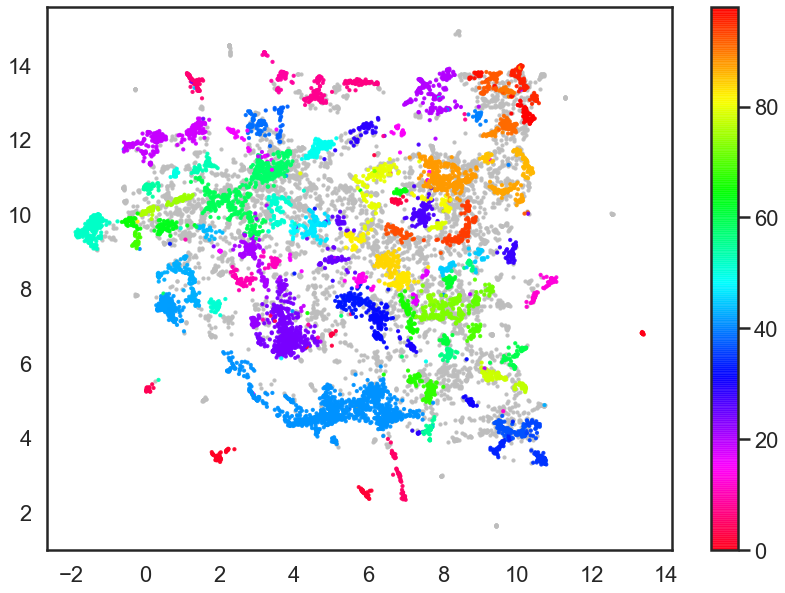

In [10]:
umap_data = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine').fit_transform(sent_embeddings)

result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]

plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=5, alpha=0.9)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=5, cmap='hsv_r', alpha=0.9)

print(len(clustered), len(outliers))
plt.colorbar()

Scatter plot to show points in space
--

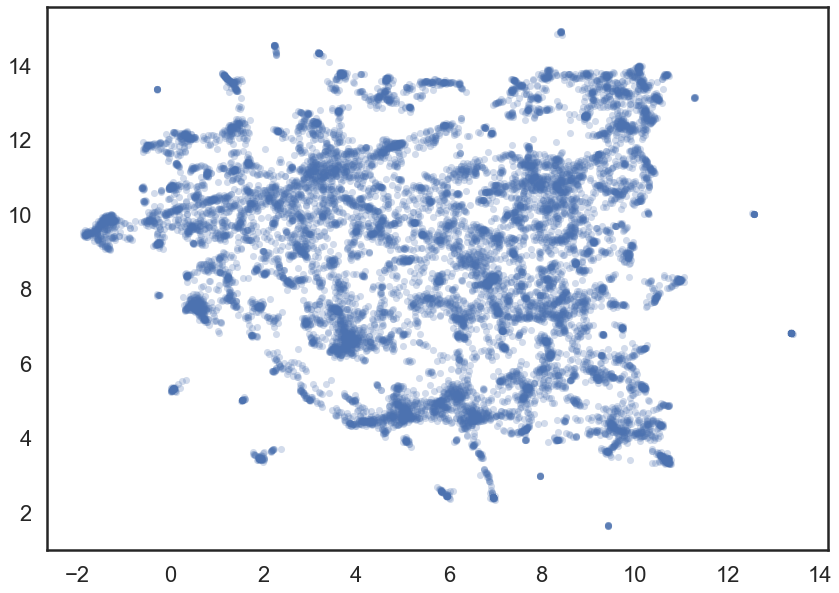

In [11]:
plt.scatter(*umap_data.T, s=50, linewidth=0, c='b', alpha=0.25)

Condensed Tree Plot from HDBSCAN
--

<AxesSubplot:ylabel='$\\lambda$ value'>

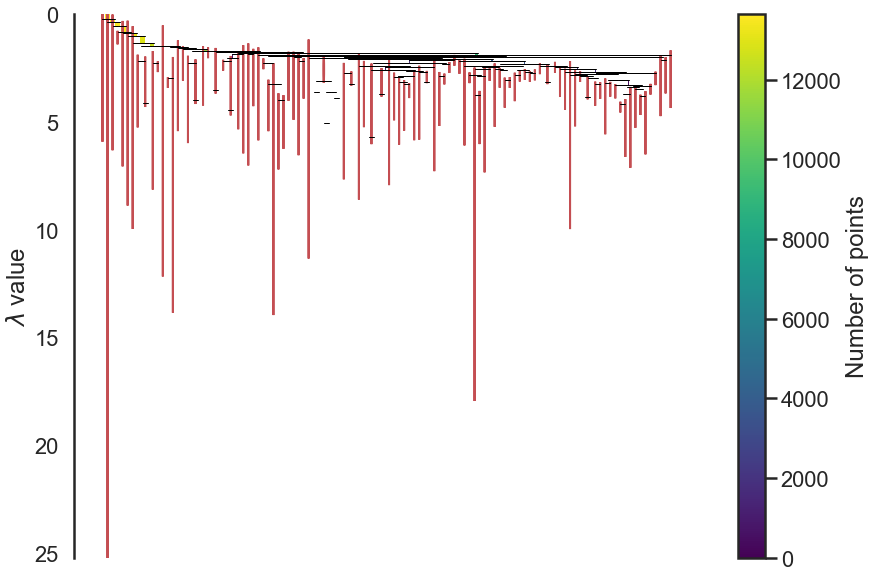

In [12]:
cluster.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette("deep",8))

Soft Clustering of the topics in space
--

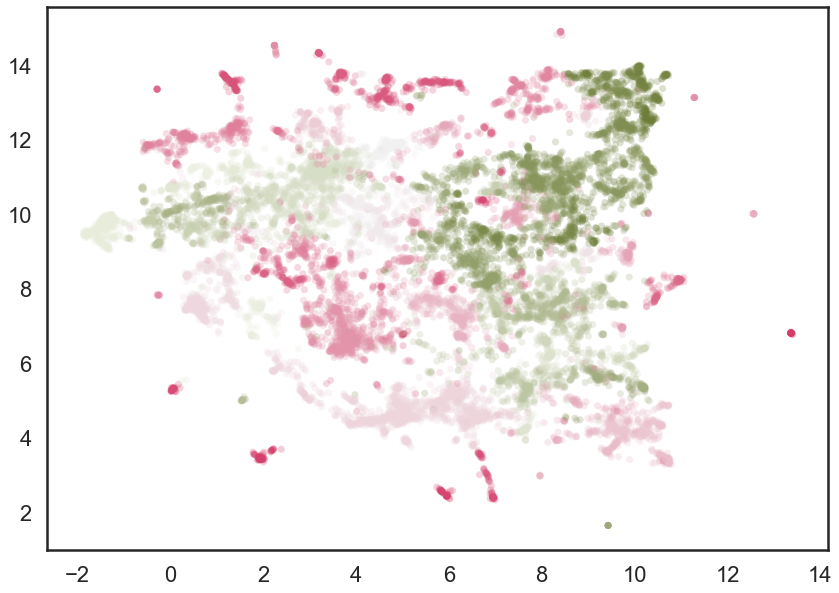

In [13]:
soft_clusters = hdbscan.all_points_membership_vectors(cluster)

color_palette = sns.diverging_palette(0, len(np.unique(clustered.labels)), n=len(np.unique(clustered.labels)))
cluster_colors = [color_palette[np.argmax(x)] for x in soft_clusters]

plt.scatter(*umap_data.T, s=50, linewidth=0, c=cluster_colors, alpha=0.25)

In [14]:
content = list(art_train["cont_title"])
title = list(art_train['contentTitle'])

Assigning Labels from Clustering to the documents
--

In [15]:
docs_df = pd.DataFrame(content, columns=["Doc"])
docs_df['Title'] = title
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

Topic based TF-IDF
--

In [16]:
def doc_tf_idf(documents, doc_length, ngram_range=(1,1)):
    """
    topic based TF-IDF to create dense clusters allowing for easily interpretable topics
    """
    count = CountVectorizer(ngram_range=ngram_range, stop_words=stop_words).fit(documents)
    terms = count.transform(documents).toarray()
    words = np.sum(terms, axis=1)
    tf = terms.T/words
    sum_terms = np.sum(terms, axis=0)
    idf = np.log(doc_length/sum_terms).reshape(-1, 1)
    tf_idf = tf * idf
    return tf_idf, count
  
tf_idf, count = doc_tf_idf(docs_per_topic.Doc.values, doc_length=len(content), ngram_range=(1,2))

In [17]:
print(f"TF-IDF Shape: {tf_idf.shape}")

TF-IDF Shape: (2967401, 100)


Creating topic words from topic numbers
--

In [18]:
def get_top_n_words(tf_idf, count, docs_per_topic, n=20):
    """
    Get the top words per topic
    """      
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_10_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_10_words

def get_topic_sizes(df):
    """
    Get the document counts clustered for all the topics.
    """    
    topic_sizes = (df.groupby(['Topic']).Doc.count().reset_index()
                   .rename({"Topic": "Topic", "Doc": "Doc_Count"}, axis='columns').sort_values("Doc_Count", ascending=False))
    return topic_sizes

top_10_words = get_top_n_words(tf_idf, count, docs_per_topic, n=10)
topic_sizes = get_topic_sizes(docs_df)
topic_sizes.head(10)

Topic  Doc_Count
0      -1       4597
42     41       1127
25     24        533
89     88        313
53     52        286
60     59        234
59     58        229
21     20        222
43     42        221
20     19        198

Top 4 topics with maximum size
--

In [20]:
top_10_words[41], top_10_words[24], top_10_words[88], top_10_words[52]

([('interview questions', 0.0026633385262659817),
  ('interviewer', 0.0024793846418907388),
  ('answers', 0.0020346354063693296),
  ('question', 0.0019755168450301267),
  ('interviewers', 0.001681829583465311),
  ('sample answers', 0.001475184266604924),
  ('developer', 0.0014222357033805504),
  ('java', 0.0014090999855557009),
  ('answer', 0.0014035932634233264),
  ('programming', 0.0013939676460291608)],
 [('objective', 0.003306326569203674),
  ('resume objective', 0.0032917210045172287),
  ('resumes', 0.0028734504589615194),
  ('cv', 0.0026260532541108874),
  ('summary', 0.002519916586101072),
  ('keywords', 0.002088334083786491),
  ('section', 0.0020298953670544614),
  ('format', 0.0018787847970783299),
  ('accomplishments', 0.0018615206507652095),
  ('awards', 0.0018031729958469405)],
 [('target', 0.0029261570281295707),
  ('consumers', 0.0028176188111935824),
  ('selling', 0.0026775035140595023),
  ('marketing strategy', 0.0022285448051681455),
  ('campaign', 0.002220362107693736

Heatmap for top 30 topics
--

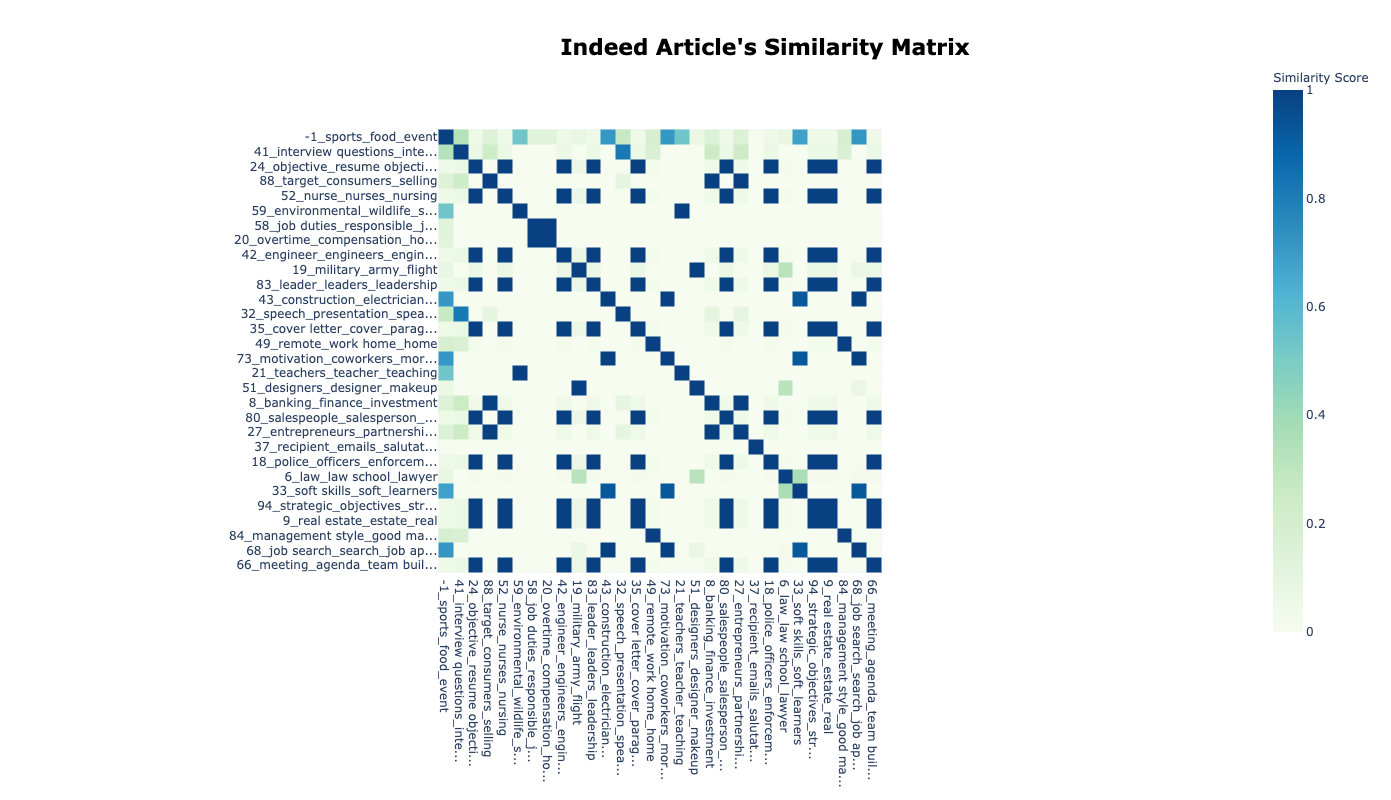

In [23]:
df = pd.DataFrame(topic_sizes).reset_index()
df = df.drop(columns=["index"])
topics = df.Topic.values.tolist()[:30]
fig, _= heatmap_visualization(tf_idf, topics, top_10_words)
fig

Heatmap for all topics
--

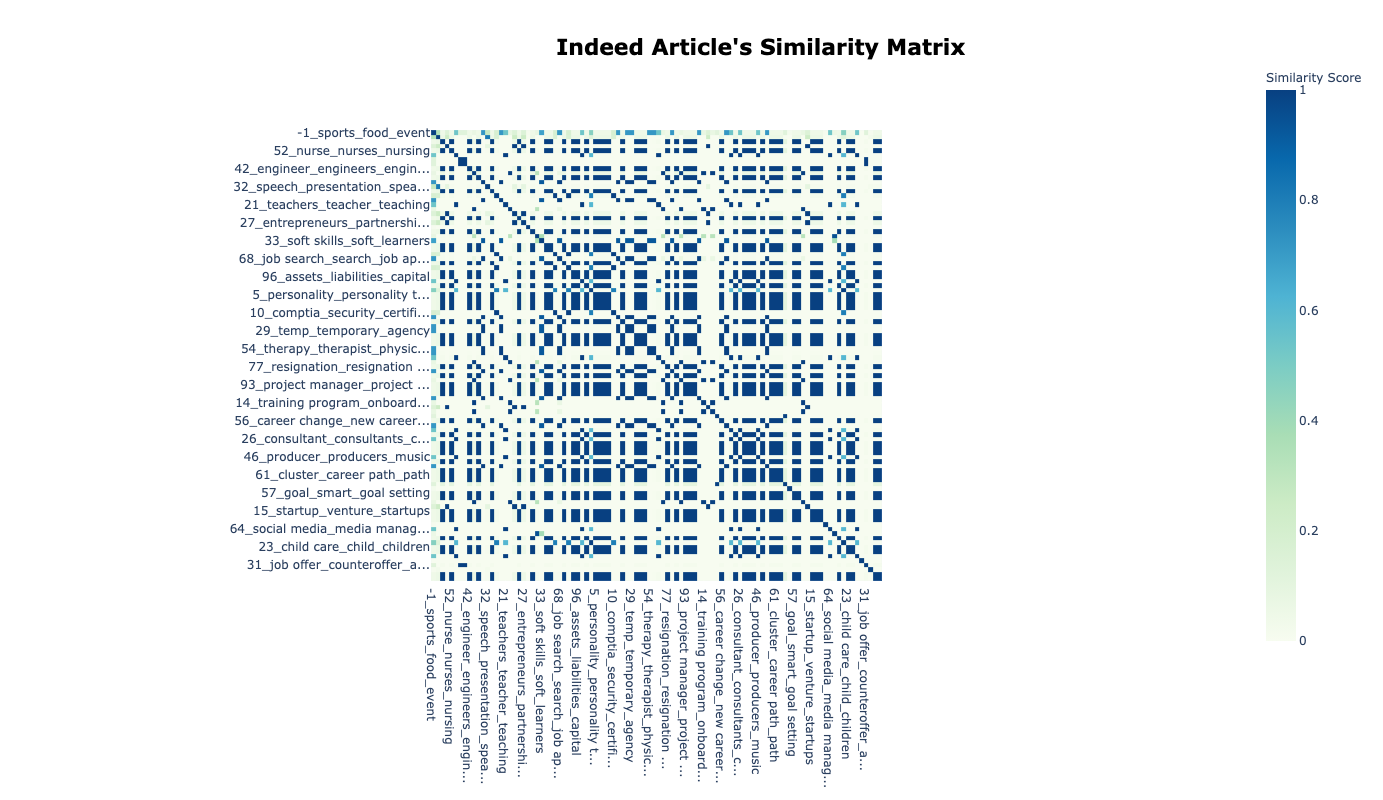

In [24]:
df = pd.DataFrame(topic_sizes).reset_index()
df = df.drop(columns=["index"])
topics = df.Topic.values.tolist()
fig, _= heatmap_visualization(tf_idf, topics, top_10_words)
fig

2-D Plotly Visualization of topics in Space
--

In [25]:
def get_colors(topics, topic_list):
    """
    Get the color marker for the topics inside the topics list
    """          
    if topics == -1:
        marker = ["#B0BEC5" for _ in topic_list[1:]]
    else:
        marker = ["red" if topic == topics else "#B0BEC5" for topic in topic_list[1:]]
    return [{'marker_color': [marker]}]   

def get_topic(topic):
    """
    Get a particular topic from all the topics
    """           
    return top_10_words[topic]

def get_topics():         
    """
    Get a all the topics in a dictionary
    """          
    return top_10_words

def get_topic_freq(topic= None):
    """
    Get document count per topic which will be the size of the topic
    """    
    if isinstance(topic, int):
        return topic_sizes[topic]
    else:
        return topic_sizes
    
def topic_visualization_fotmatting(df, topic_list, width, height):
    """
    Format topic visulization using the co-ordinates provided in the datafarme and list of topics
    """
    # Prepare figure range
    x_range = (df.x.min() - abs((df.x.min()) * .15), df.x.max() + abs((df.x.max()) * .15))
    y_range = (df.y.min() - abs((df.y.min()) * .15), df.y.max() + abs((df.y.max()) * .15))

    # Plot topics
    fig = px.scatter(df, x="x", y="y", size="Size", size_max=40, template="simple_white", labels={"x": "", "y": ""},
                     hover_data={"x": False, "y": False, "Topic": True, "Words": True, "Size": True})
    fig.update_traces(marker=dict(color="#7f91eb", line=dict(width=2, color='DarkSlateGrey'))) #"#B0BEC5"

    # Update hover order
    fig.update_traces(hovertemplate="<br>".join(["<b>Topic %{customdata[0]}</b>",
                                                 "Words: %{customdata[1]}",
                                                 "Count: %{customdata[2]}"]))   
    
    # Create a slider for topic selection
    steps = [dict(label=f"Topic {topic}", method="update", args=get_colors(topic,topic_list)) for topic in topic_list[1:]]
    sliders = [dict(active=0, pad={"t": 50}, steps=steps)]

    # Stylize layout
    fig.update_layout(
                        title={'text': "<b>Indeed's Intertopic Distance", 'y': .95, 'x': 0.5, 'xanchor': 'center', 'yanchor': 'top', 'font': dict(size=22,color="Black")},
                        width=width,
                        height=height,
                        hoverlabel=dict(
                            bgcolor="white",
                            font_size=14,
                            font_family="Rockwell"
        ),
        xaxis={"visible": False},
        yaxis={"visible": False},
        sliders=sliders
    )

    fig.update_xaxes(range=x_range)
    fig.update_yaxes(range=y_range)


    fig.add_shape(type="line",
                  x0=sum(x_range)/2, y0=y_range[0], x1=sum(x_range) / 2, y1=y_range[1],
                  line=dict(color="#CFD8DC", width=2))
    fig.add_shape(type="line",
                  x0=x_range[0], y0=sum(y_range)/2, x1=x_range[1], y1=sum(y_range) / 2,
                  line=dict(color="#9E9E9E", width=2))
    fig.add_annotation(x=x_range[0], y=sum(y_range) / 2, text="D1", showarrow=False, yshift=10)
    fig.add_annotation(y=y_range[1], x=sum(x_range) / 2, text="D2", showarrow=False, xshift=10)
    fig.data = fig.data[::-1]

    return fig

In [26]:
def topics_viz_data(topics, width, height):
    """
    Creates Topic Visalization in 2D space. Each topic taking shape as the sice of the documents clustered in each topic
    """       
    topics = sorted(list(get_topics().keys()))
    frequencies = [topic_sizes[topic_sizes["Topic"]==topic]["Doc_Count"].values[0] for topic in topics]
    words = [" | ".join([word[0] for word in get_topic(topic)[:5]]) for topic in topics]

    indices = np.array([topics.index(topic) for topic in topics])

    embeddings = tf_idf[indices]
    embeddings = MinMaxScaler().fit_transform(embeddings)
    embeddings = umap.UMAP(n_neighbors=2, n_components=2, metric='hellinger').fit_transform(embeddings)

    df = pd.DataFrame({"x": embeddings[1:, 0], "y": embeddings[1:, 1],
                       "Topic": topics[1:], "Words": words[1:], "Size": frequencies[1:]})
    fig = topic_visualization_fotmatting(df, topics, width, height)

    return fig, embeddings, df


In [27]:
def visualize_topics(topics = None, width = 1000, height = 1000):
    """
    Format topic visulization using the co-ordinates provided in the datafarme and list of topics
    """    
    fig,_,_= topics_viz_data(topics=topics,
                             width=width,
                             height=height)
    return fig

In [36]:
topics = docs_per_topic.Topic.tolist()
fig = visualize_topics(topics)

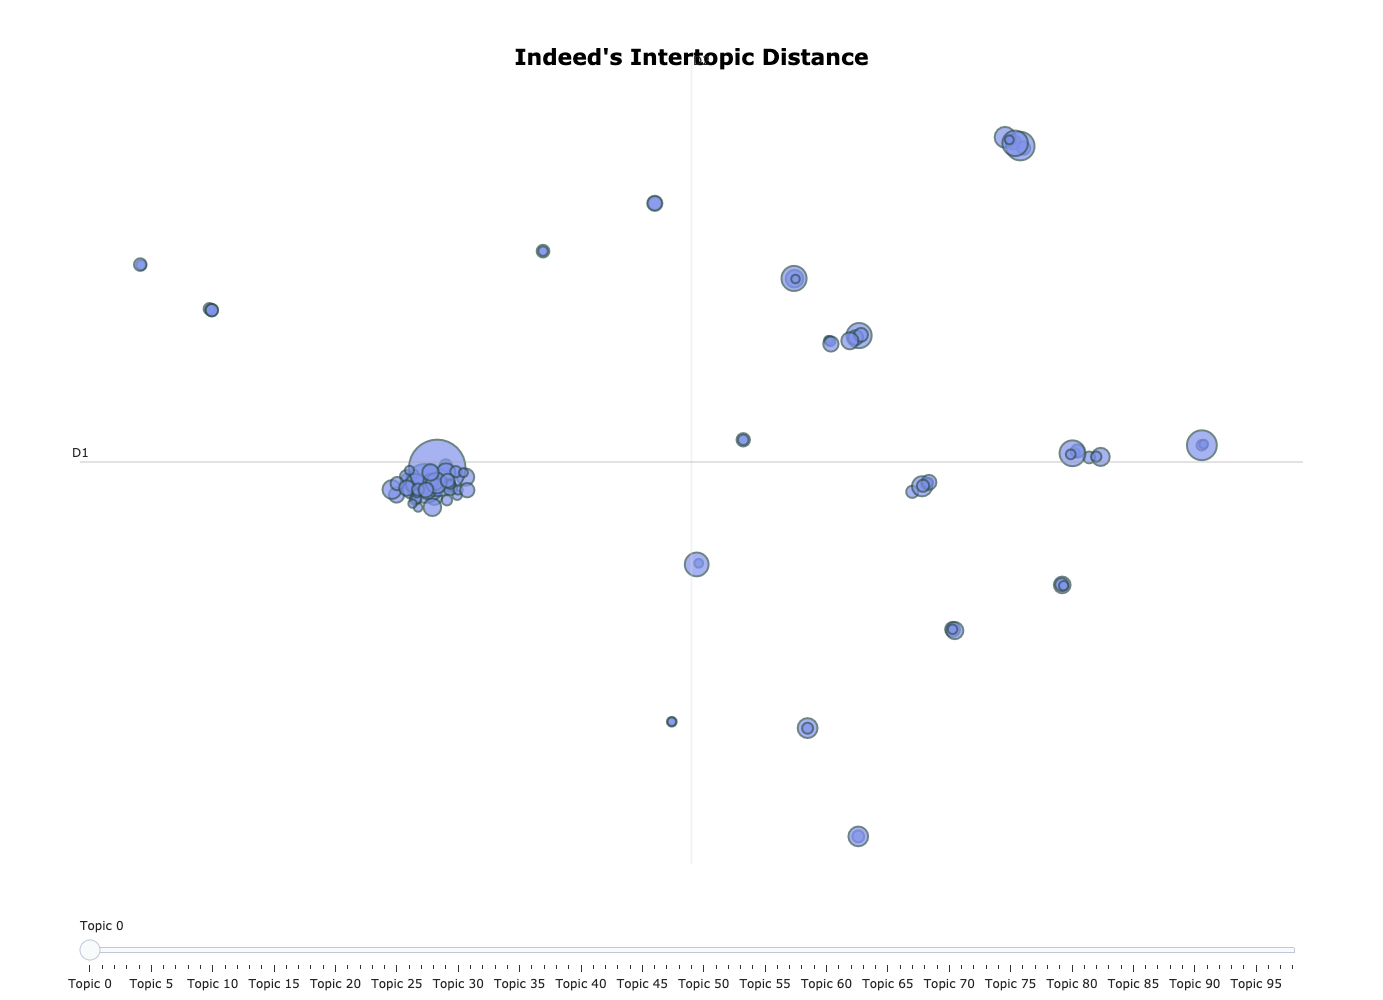

In [29]:
fig

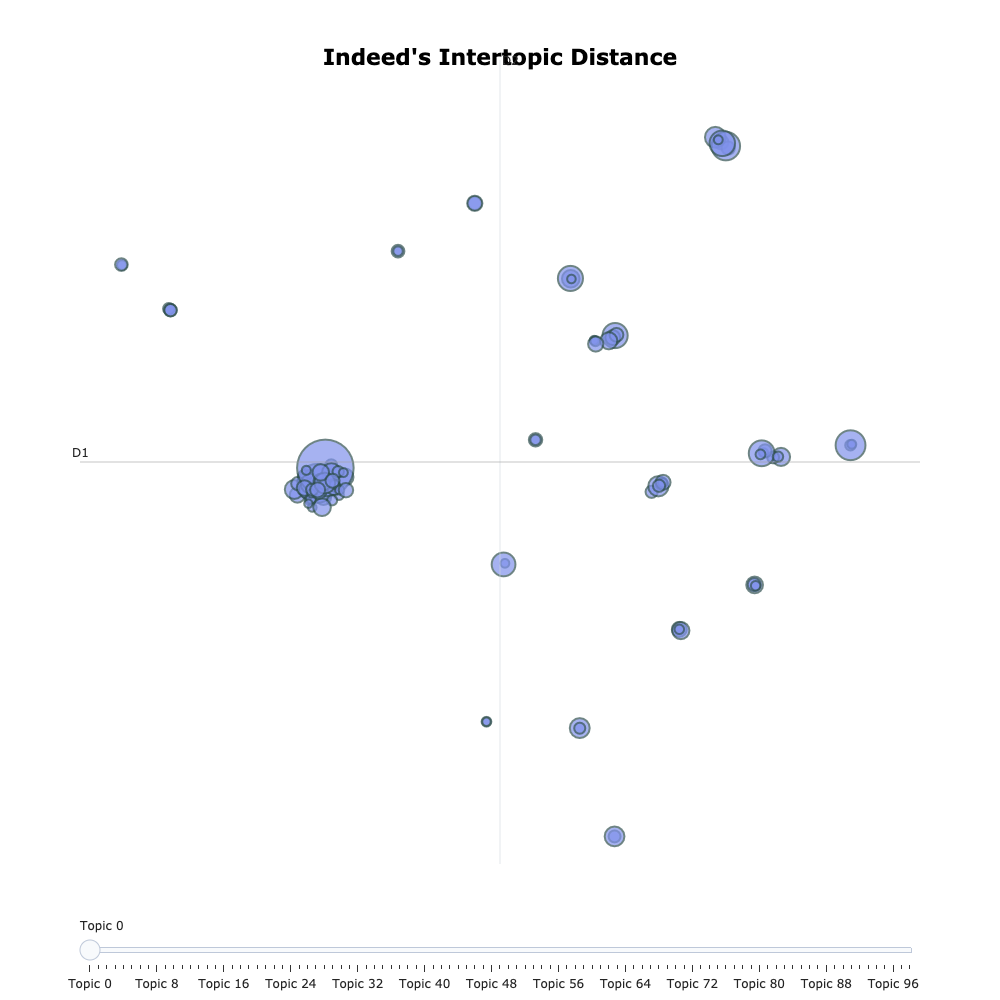

In [35]:
from IPython.display import Image
Image(filename="/Users/gurpreetbedi/Downloads/newplot (2).png") 

**Note: This figure is interactive, know plotly issue due to which the figure is not visible on Github.**

Topic Dendograms depicting the hierarchy of topics
--

In [30]:
def topics_dendrogram(embeddings, orientation="left", width = 1000, height = 1000):
    """
    Creates a Dendogram in topic space using sentence transformer embeddings
    """    
    embeddings = np.array(embeddings)
    topics_list = sorted(list(get_topics().keys()))
    topics_lookup = {topic:i for i, topic in enumerate(topics_list)}
    indices = np.array([topics_lookup[topic] for topic in topics_list])
    embeddings = embeddings[indices]

    # Create dendogram
    distance_matrix = 1 - cosine_similarity(embeddings)
    fig = ff.create_dendrogram(distance_matrix,
                               orientation=orientation,
                               linkagefun=lambda x: linkage(x, "ward"),
                               color_threshold=1)

    # Create nicer labels
    axis = "yaxis" if orientation == "left" else "xaxis"
    new_labels = [[[str(topics_list[int(x)]), None]] + get_topic(topics_list[int(x)])
                  for x in fig.layout[axis]["ticktext"]]
    new_labels = ["_".join([label[0] for label in labels[:4]]) for labels in new_labels]
    new_labels = [label if len(label) < 30 else label[:27] + "..." for label in new_labels]

    # Stylize layout
    fig.update_layout(plot_bgcolor="#ECEFF1",
                      template="plotly_white",
                      title={'text': "<b>Indeed's Article Clustering", "y": .95, "x": 0.5, "xanchor": 'center', "yanchor": "top", "font": dict(size=22, color="Black")},
                      width=width,
                      height=height,
                      hoverlabel=dict(bgcolor="white", font_size=16,font_family="Rockwell"),

    )

    # Stylize orientation
    if orientation == "left":
        fig.update_layout(yaxis=dict(tickmode="array",
                                     ticktext=new_labels))
    else:
        fig.update_layout(xaxis=dict(tickmode="array",
                                     ticktext=new_labels))
    return fig

Create Topic embeddings
--

In [31]:
def create_topic_embeddings(embeddings):
    topic_list = list(get_topics().keys())
    topic_list.sort()
    topic_embeddings = []
    for i, topic in enumerate(topic_list):
        indexes = np.array(docs_df[docs_df["Topic"]==topic].index)
        topic_embedding = np.average(embeddings[indexes], axis=0)
        topic_embeddings.append(topic_embedding)
    return topic_embeddings

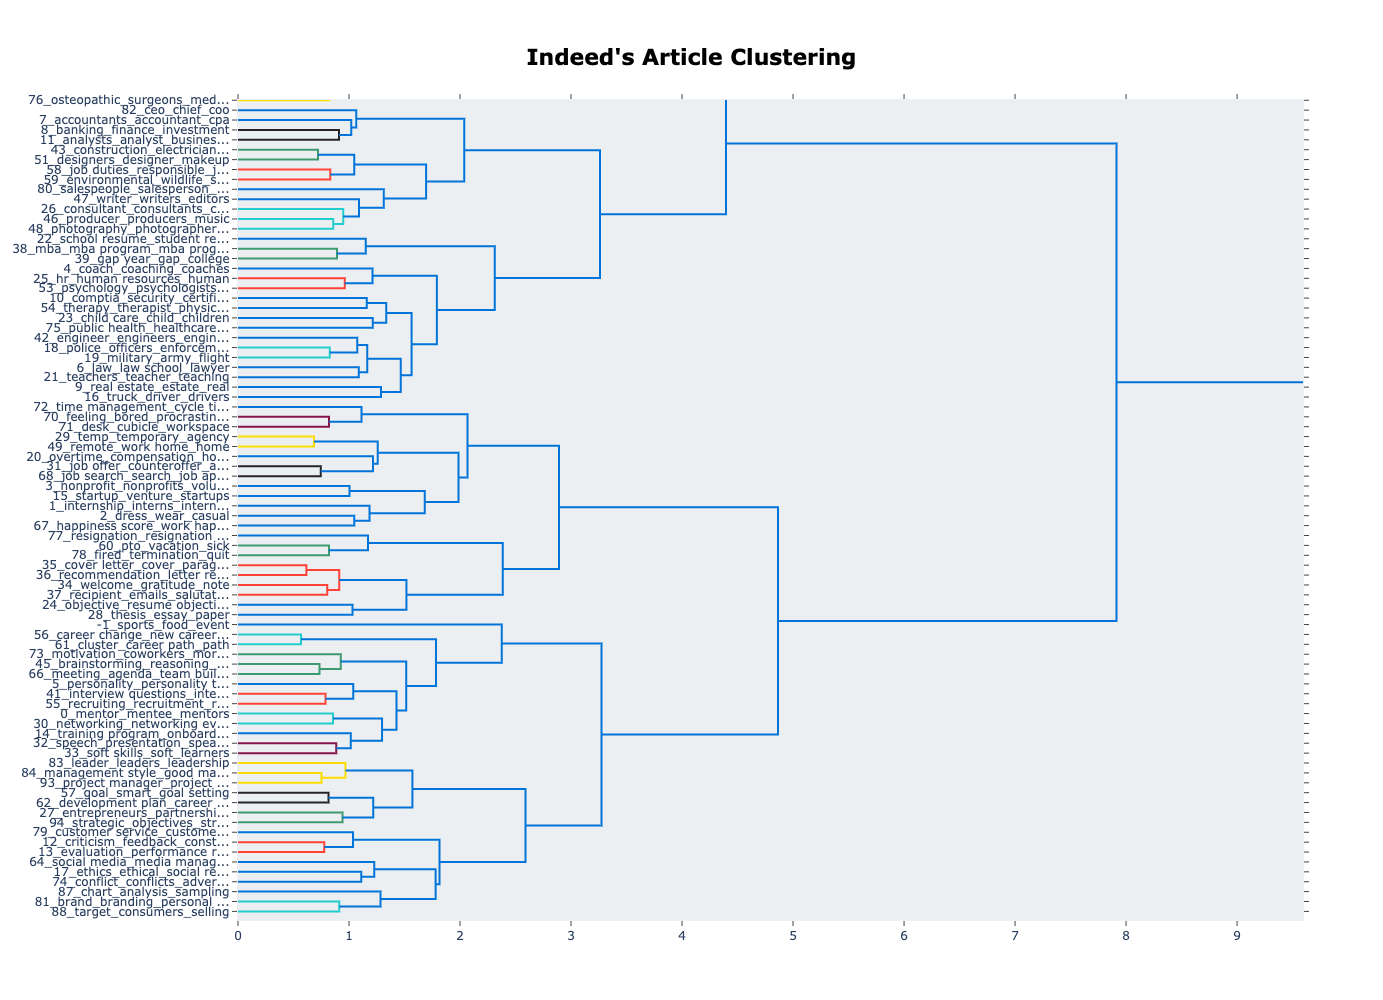

In [32]:
topic_embeddings_97 = create_topic_embeddings(sent_embeddings)
fig = topics_dendrogram(embeddings=topic_embeddings_97)
fig

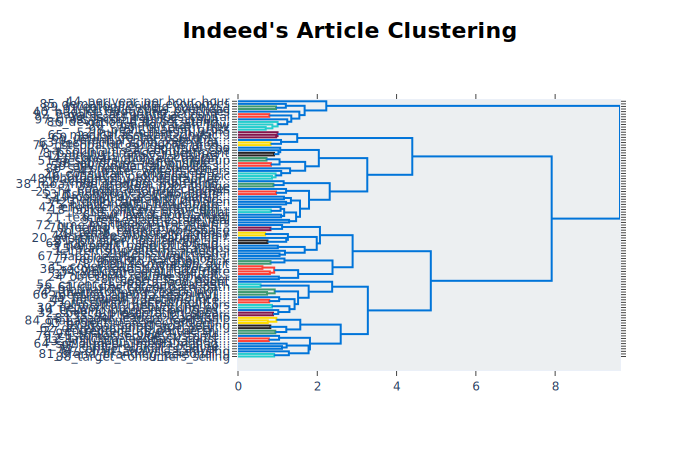

In [33]:
fig.show("svg")

Zoomed in View
--

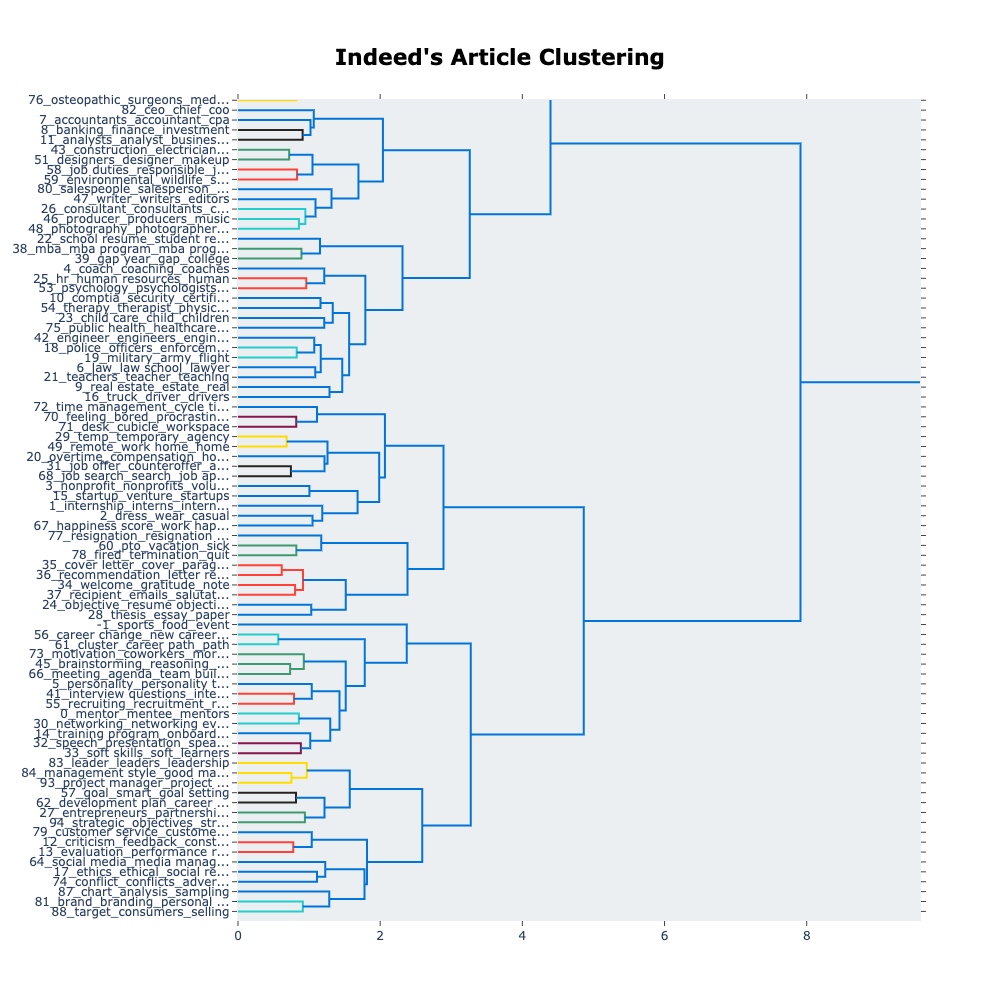

In [34]:
from IPython.display import Image
Image(filename="/Users/gurpreetbedi/Downloads/newplot (1).png") 

Merging Two Topic (if required)
--
**Note: Only run it if you know what topics to merge, otherwise skip it.** 
**Useful in the case when there are some topics which user wants then to be merged together.**

In [37]:
def merge_topics(topic_to_merge, topic_to_merge_into):
    """
    Merge the Topics if required
    """
    print(f"""
    Topic to be merged {topic_to_merge}:
    {top_10_words[topic_to_merge]}
    Topics to merge into {topic_to_merge_into}:
    {top_10_words[topic_to_merge_into]}
    \n
    """)

    docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
    old_topics = docs_df.sort_values("Topic").Topic.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    docs_df.Topic = docs_df.Topic.map(map_topics)
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Title': ' '.join})
    m = len(content)
    tf_idf, count = doc_tf_idf(docs_per_topic.Title.values, m)
    top_words = get_top_n_words(tf_idf, count, docs_per_topic, n=10)
    topic_sizes = get_topic_sizes(docs_df)
    return tf_idf, count, top_words, topic_sizes

tf_idf, count, top_10_words, topic_sizes = merge_topics(topic_to_merge=0,topic_to_merge_into=0)
topic_sizes.head(10)

New articles Predictions using Tf-IDF
--

In [38]:
contents = list(art_test["cont_title"])
test_title = art_test["contentTitle"].tolist()

embedding_model = "msmarco-MiniLM-L-12-v3"
device = "cuda" if torch.cuda.is_available else "cpu"
test_embeddings = Sentence_Encoder(embedding_model).embed_documents(contents, device=device)

In [39]:
test_embeddings.shape

torch.Size([1417, 384])

In [40]:
test_umap_embeddings = umap_model.transform(test_embeddings)

In [41]:
test_umap_embeddings.shape

(1417, 10)

In [42]:
predictions, _ = hdbscan.approximate_predict(hdbscan_model, test_umap_embeddings)
probabilities = hdbscan.all_points_membership_vectors(cluster)
outlier_score = hdbscan.approximate_predict_scores(hdbscan_model, test_umap_embeddings)

Percentage distribution of Topic with respect to aricles
--

In [44]:
new_preds = defaultdict(list)
top_words = defaultdict(list)

for j, title in enumerate(art_test["contentTitle"].tolist()):
    for i in np.argsort(probabilities[j],axis=0)[::-1][:10]:
        new_preds["Title"].append(title)
        words = top_10_words[i]
        check = []
        for word in words:
            check.append(word[0])
        new_preds["Perc"].append(round(probabilities[j][i],5))
        new_preds["Top Words"].append(check)
        
new_df = pd.DataFrame.from_dict(new_preds)

In [45]:
new_df.iloc[:10]

Title     Perc  \
0  How To Tell Someone "That's Not My Job" (With Tips and Examples)  0.06918   
1  How To Tell Someone "That's Not My Job" (With Tips and Examples)  0.03977   
2  How To Tell Someone "That's Not My Job" (With Tips and Examples)  0.02683   
3  How To Tell Someone "That's Not My Job" (With Tips and Examples)  0.02039   
4  How To Tell Someone "That's Not My Job" (With Tips and Examples)  0.01726   
5  How To Tell Someone "That's Not My Job" (With Tips and Examples)  0.01700   
6  How To Tell Someone "That's Not My Job" (With Tips and Examples)  0.01661   
7  How To Tell Someone "That's Not My Job" (With Tips and Examples)  0.01501   
8  How To Tell Someone "That's Not My Job" (With Tips and Examples)  0.01478   
9  How To Tell Someone "That's Not My Job" (With Tips and Examples)  0.01390   

                                                                                                                                                                                             Top Words  
0                                                                           [time management, cycle time, polychronic, daily schedule, task, pomodoro, schedule, polychronic time, deadlines, morning]  
1                                                                                                       [desk, cubicle, workspace, supplies, clutter, space, office supplies, decor, items, organized]  
2                                                                        [feeling, bored, procrastination, overworked, stress, bored work, overthinking, disengaged, afternoon slump, procrastinating]  
3                                                                                           [motivation, coworkers, morale, motivated, respect, coworker, coworking, attitude, confidence, colleagues]  
4                                                                                   [cluster, career path, path, us jtp, jtp, careeradvice us, careeradvice, career interests, careers, career advice]  
5                                        [conflict, conflicts, adversity, conflict management, conflict interest, resolution, task conflict, conflict theory, conflict workplace, conflict resolution]  
6  [development plan, career development, personal development, career planning, career plan, career management, development goals, professional development, career advancement, professional growth]  
7                                                                                                             [pto, vacation, sick, days, vacation time, absence, leave, paid time, sick days, policy]  
8                                                                        [career change, new career, change careers, changing careers, careers, midlife, changing, change, current career, transition]  
9                                                                                         [goal, smart, goal setting, setting, setting goals, smart goals, smart goal, measurable, achieving, achieve]

In [46]:
new_df.to_csv("/Users/gurpreetbedi/Downloads/Neural/predictions_97_topic_distr.csv")

Approximate pedictions for the test data
--

In [58]:
new_preds = defaultdict(list)
top_words = defaultdict(list)

for j, (title, pred, out) in enumerate(zip(art_test["contentTitle"].tolist(), predictions, outlier_score)):
    for i in np.argsort(probabilities[j],axis=0)[::-1][:1]:
        new_preds["Title"].append(title)
        words = top_10_words[pred]
        check = []
        for word in words:
            check.append(word[0])  
        new_preds["Topic"].append(pred)                        
        new_preds["Top_Words"].append(check)
        
new_df = pd.DataFrame.from_dict(new_preds)
print(f"Number of outliers: {len([p for p in new_df.Topic.tolist() if p==-1])}")

Number of outliers: 1327


In [59]:
new_df.head(10)

Title  Topic  \
0  How To Tell Someone "That's Not My Job" (With Tips and Examples)     -1   
1             What Is the Theory of Constraints and How Is It Used?     -1   
2     What Is Thinking Strategically? Definition and How To Improve     -1   
3     Thinking vs. Feeling in the Workplace: What's the Difference?     -1   
4                               17 Tips for Working With New Bosses     -1   
5                   5 To-Do List Methods for Improving Productivity     -1   
6                                    20 DevOps Tools and Their Uses     -1   
7   6 of the Toughest Sales Interview Questions with Sample Answers     -1   
8               How To Train the Team: Team Training Types and Tips     -1   
9                      What Are the Benefits of Six Sigma Training?     -1   

                                                                           Top_Words  
0  [sports, food, event, risk, price, relations, call, report, organizational, game]  
1  [sports, food, event, risk, price, relations, call, report, organizational, game]  
2  [sports, food, event, risk, price, relations, call, report, organizational, game]  
3  [sports, food, event, risk, price, relations, call, report, organizational, game]  
4  [sports, food, event, risk, price, relations, call, report, organizational, game]  
5  [sports, food, event, risk, price, relations, call, report, organizational, game]  
6  [sports, food, event, risk, price, relations, call, report, organizational, game]  
7  [sports, food, event, risk, price, relations, call, report, organizational, game]  
8  [sports, food, event, risk, price, relations, call, report, organizational, game]  
9  [sports, food, event, risk, price, relations, call, report, organizational, game]

In [60]:
new_df.to_csv("/Users/gurpreetbedi/Downloads/Neural/predictions_97_hard_predictions.csv")

Checking out the if the probability score is different than approximate prediction 
--

In [61]:
new_preds = defaultdict(list)
top_words = defaultdict(list)

for j, (title, pred, out) in enumerate(zip(art_test["contentTitle"].tolist(), predictions, outlier_score)):
    for i in np.argsort(probabilities[j],axis=0)[::-1][:1]:
        new_preds["Title"].append(title)
        if probabilities[j][i] < 0.9 :
            words = top_10_words[pred]
        else:
            words = top_10_words[i]
        if probabilities[j][i] < 0.9 :
            new_preds["Topic"].append(pred)  
        else:
            new_preds["Topic"].append(i)            
        check = []
        for word in words:
            check.append(word[0])           
        new_preds["Perc"].append(round(probabilities[j][i],5))
        new_preds["Outlier_score"].append(out)
        new_preds["Top_Words"].append(check)
        
new_df = pd.DataFrame.from_dict(new_preds)
print(f"Number of outliers: {len([p for p in new_df.Topic.tolist() if p==-1])}")

Number of outliers: 1026


In [62]:
new_df.head(10)

Title  Topic  \
0  How To Tell Someone "That's Not My Job" (With Tips and Examples)     -1   
1             What Is the Theory of Constraints and How Is It Used?     -1   
2     What Is Thinking Strategically? Definition and How To Improve     -1   
3     Thinking vs. Feeling in the Workplace: What's the Difference?     32   
4                               17 Tips for Working With New Bosses     -1   
5                   5 To-Do List Methods for Improving Productivity     -1   
6                                    20 DevOps Tools and Their Uses     -1   
7   6 of the Toughest Sales Interview Questions with Sample Answers     -1   
8               How To Train the Team: Team Training Types and Tips     -1   
9                      What Are the Benefits of Six Sigma Training?     -1   

      Perc  Outlier_score  \
0  0.06918       0.957885   
1  0.25753       0.955860   
2  0.02430       0.933403   
3  1.00000       0.956064   
4  0.20082       0.933356   
5  0.19920       0.914181   
6  0.29094       0.956397   
7  0.01374       0.990830   
8  0.05878       0.918740   
9  0.03339       0.935808   

                                                                                                         Top_Words  
0                                [sports, food, event, risk, price, relations, call, report, organizational, game]  
1                                [sports, food, event, risk, price, relations, call, report, organizational, game]  
2                                [sports, food, event, risk, price, relations, call, report, organizational, game]  
3  [speech, presentation, speaker, speaking, nonverbal, body language, audience, listening, message, conversation]  
4                                [sports, food, event, risk, price, relations, call, report, organizational, game]  
5                                [sports, food, event, risk, price, relations, call, report, organizational, game]  
6                                [sports, food, event, risk, price, relations, call, report, organizational, game]  
7                                [sports, food, event, risk, price, relations, call, report, organizational, game]  
8                                [sports, food, event, risk, price, relations, call, report, organizational, game]  
9                                [sports, food, event, risk, price, relations, call, report, organizational, game]

In [63]:
new_df.to_csv("/Users/gurpreetbedi/Downloads/Neural/predictions_97_checking with probablities.csv")